In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Tue Jun 28 15:17:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 29%   37C    P8    21W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 27%   

# MongoDB

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_us = db.rm_patent_us
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2013 = db.rm_patent_us_2013
    db_rm_us_2013 = db.rm_patent_us_2013
    # db_rm_de_2013 = db.rm_patent_de_2013
except errors.ConnectionFailure as err:
    print(err)

# 2013

## Company數量

In [6]:
data_assignee = db_rm_us_2013.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [7]:
# 取總數前15家公司
# final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
df_family_us.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(16)

,company,count
2,Cisco Technology Inc,38
13,LG Electronics Inc,13
17,Qualcomm Inc,12
25,Telefonaktiebolaget LM Ericsson AB,10
11,IoT Holdings Inc,7
28,ZTE Corp,5
27,Xerox Corp,4
5,Electronics and Telecommunications Research In...,4
9,Intel Corp,4
10,Intel Deutschland GmbH,4


In [8]:
# com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_df = df_family_us.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_df.reset_index(drop=True, inplace=True)

In [9]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))
com_df

,company,count,count_log
0,Cisco Technology Inc,38,3.637586
1,LG Electronics Inc,13,2.564949
2,Qualcomm Inc,12,2.484907
3,Telefonaktiebolaget LM Ericsson AB,10,2.302585
4,IoT Holdings Inc,7,1.945910
5,ZTE Corp,5,1.609438
6,Xerox Corp,4,1.386294
7,Electronics and Telecommunications Research In...,4,1.386294
8,Intel Corp,4,1.386294
9,Intel Deutschland GmbH,4,1.386294


In [10]:
com_ls = list(com_df.company)

## Data

In [11]:
ccontry = pd.read_csv("../patent/code/依年分/rm_company_country_us_2013.csv")
ccpc = pd.read_csv("../LDA/company_lda_brief_us_2013.csv")

In [12]:
ccontry[ccontry.company.isin(com_ls)]

,company,AU,BR,CA,CN,DE,DK,EC,EP,ES,...,MX,MY,NZ,PH,PL,PT,RU,SA,TW,US
1,Alcatel Lucent SAS,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
11,Cisco Technology Inc,0.0,0.0,3.0,11.0,0.0,0.0,0.0,15.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0
14,Electronics and Telecommunications Research In...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
19,Huawei Technologies Co Ltd,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
23,Intel Corp,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0
24,Intel Deutschland GmbH,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
26,IoT Holdings Inc,0.0,0.0,0.0,2.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,8.0
30,LG Electronics Inc,1.0,0.0,1.0,8.0,0.0,0.0,0.0,7.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.0
37,NTT Docomo Inc,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
41,Nokia Technologies Oy,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0


## Similarity計算

### Country

- 換成機率  

In [13]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

### PBC
- 和Samsung Electronics Co Ltd比較

In [14]:
ccontry_pbc = ccontry2.loc[com_ls,:].copy()
ccontry_pbc.head()

,AU,BR,CA,CN,DE,DK,EC,EP,ES,FR,...,MX,MY,NZ,PH,PL,PT,RU,SA,TW,US
company,,,,,,,,,,,,,,,,,,,,,
Cisco Technology Inc,0.000000,0.0,0.044118,0.161765,0.0,0.000000,0.000000,0.220588,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.558824
LG Electronics Inc,0.021277,0.0,0.021277,0.170213,0.0,0.000000,0.000000,0.148936,0.000000,0.0,...,0.021277,0.0,0.0,0.0,0.000000,0.000000,0.021277,0.000000,0.000000,0.276596
Qualcomm Inc,0.000000,0.0,0.000000,0.145455,0.0,0.000000,0.018182,0.163636,0.018182,0.0,...,0.036364,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.018182,0.054545,0.218182
Telefonaktiebolaget LM Ericsson AB,0.000000,0.0,0.000000,0.100000,0.0,0.033333,0.000000,0.266667,0.033333,0.0,...,0.000000,0.0,0.0,0.0,0.033333,0.033333,0.033333,0.000000,0.000000,0.333333
IoT Holdings Inc,0.000000,0.0,0.000000,0.074074,0.0,0.000000,0.000000,0.259259,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.185185,0.296296


In [15]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### CPC

In [16]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [17]:
ccpc_pbc = ccpc2.loc[com_ls,:].copy()
# ccpc_pbc

In [18]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

## Scatter Plot

In [19]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

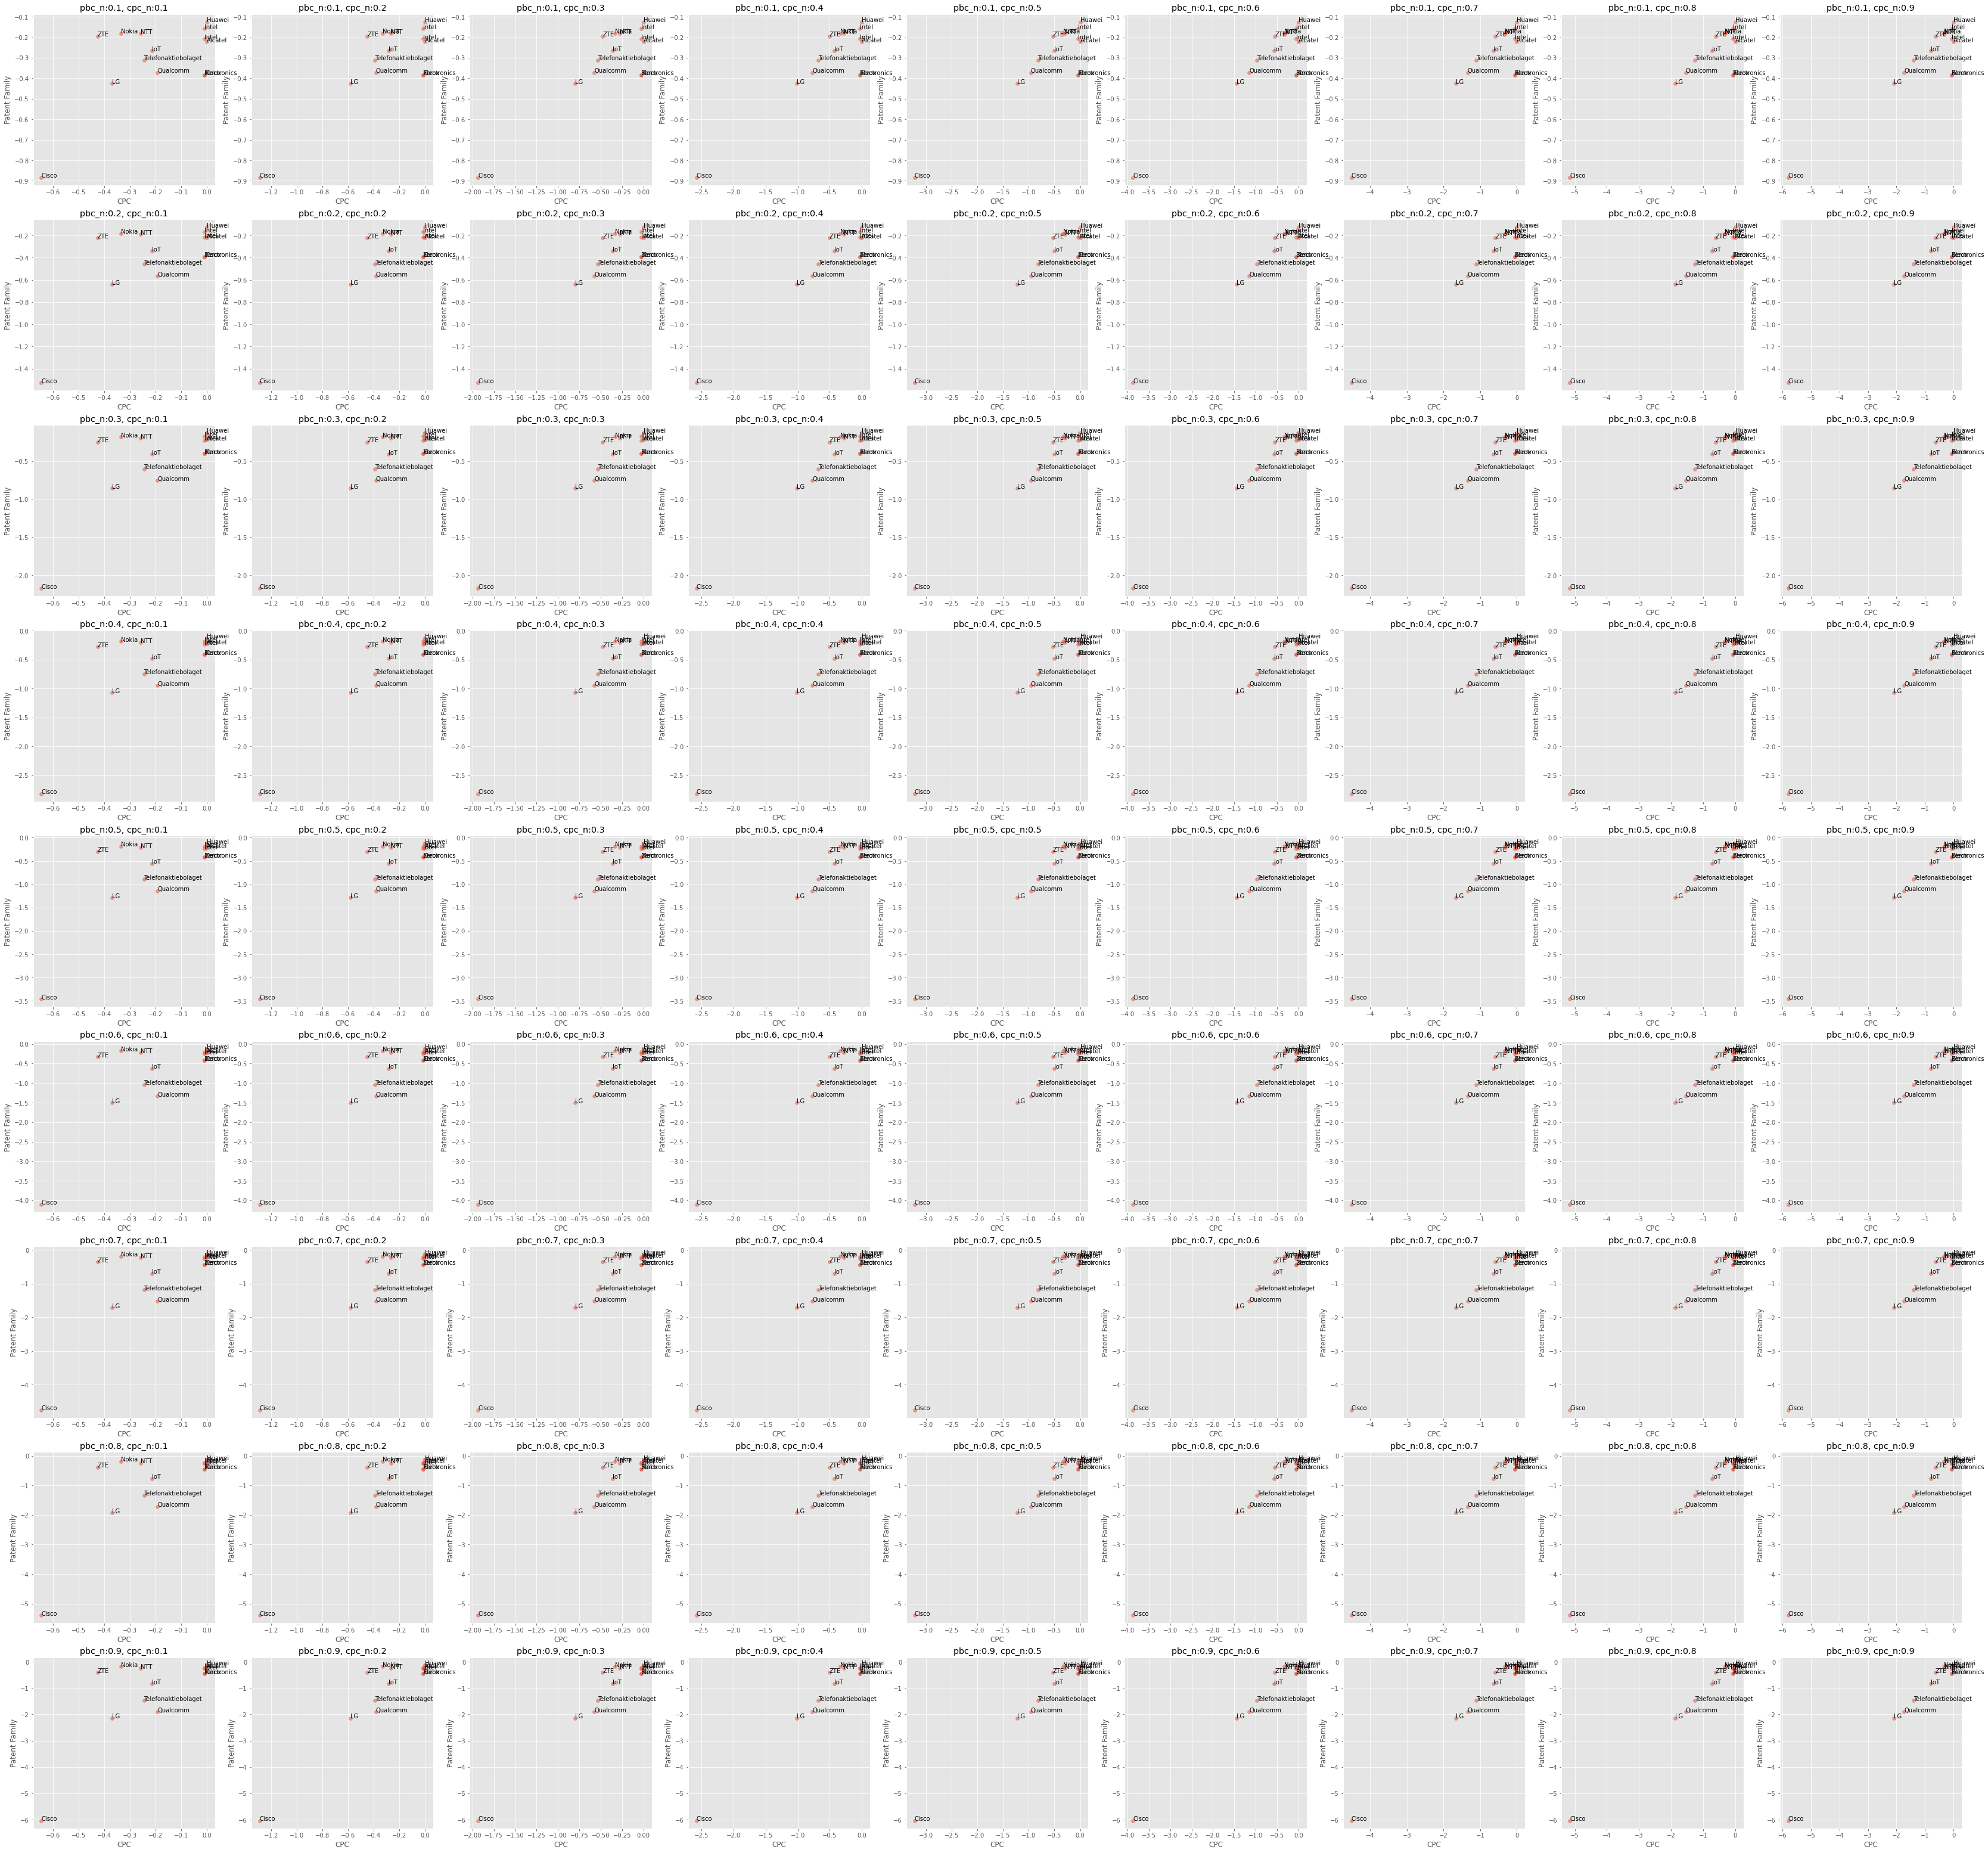

In [20]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_us_brief_2013_1.png'.format(pbc_n))

In [21]:
c_df

,cpc,country
company,,
Cisco Technology Inc,5.801749,6.040720
LG Electronics Inc,2.088976,2.145236
Qualcomm Inc,1.729631,1.909176
Telefonaktiebolaget LM Ericsson AB,1.404595,1.471262
IoT Holdings Inc,0.788979,0.840567
ZTE Corp,0.634849,0.403966
Xerox Corp,0.074485,0.449485
Electronics and Telecommunications Research Institute ETRI,0.074485,0.449485
Intel Corp,0.074485,0.274485


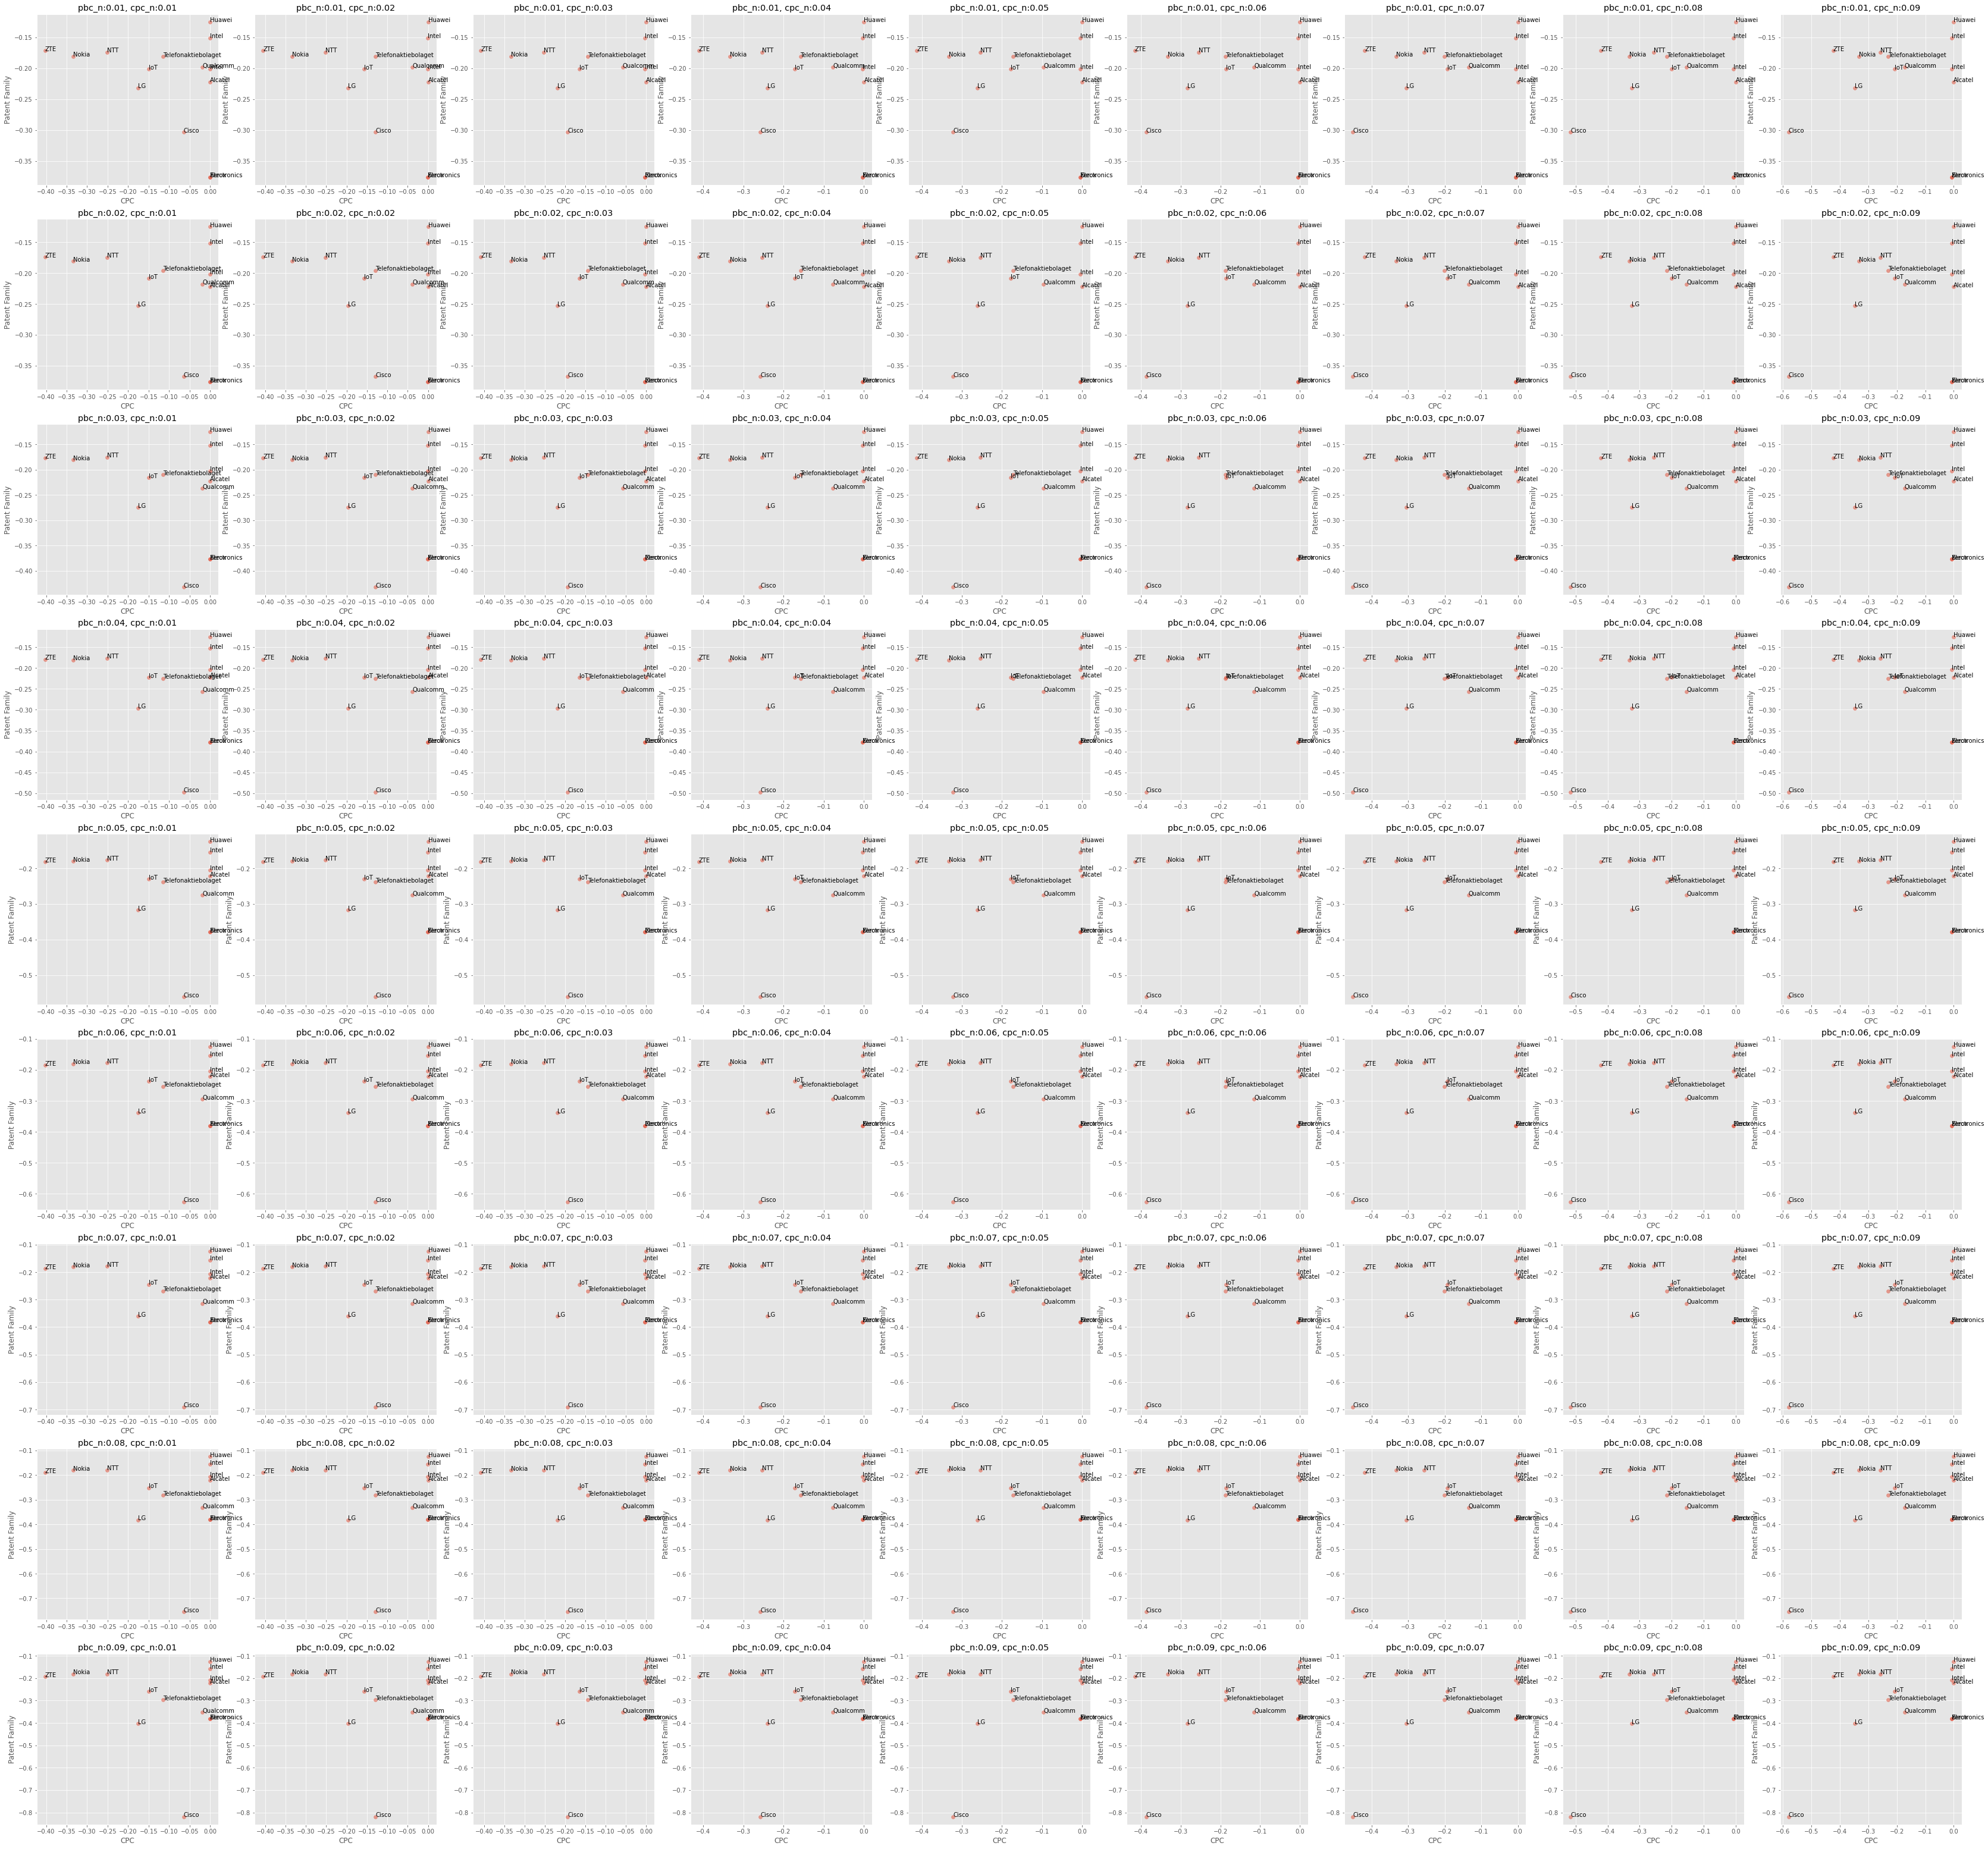

In [22]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_us_brief_2013_2.png'.format(pbc_n))

In [23]:
c_df

,cpc,country
company,,
Cisco Technology Inc,0.580175,0.819146
LG Electronics Inc,0.347359,0.403619
Qualcomm Inc,0.172963,0.352509
Telefonaktiebolaget LM Ericsson AB,0.230460,0.297126
IoT Holdings Inc,0.207469,0.259057
ZTE Corp,0.423485,0.192603
Xerox Corp,0.007448,0.382448
Electronics and Telecommunications Research Institute ETRI,0.007448,0.382448
Intel Corp,0.007448,0.207448


In [24]:
c_df = scatter_plot(pbc_n,cpc_n)
c_df = c_df.reset_index()
c_df["company"] = c_df.company.apply(lambda x: x.replace(" Inc","")\
                                                    .replace(" Co Ltd","")\
                                                    .replace(" Co. Ltd.","")\
                                                    .replace(" Co., Ltd.","")\
                                                    .replace(" Ltd","")\
                                                    .replace(" Corp","")\
                                                    .replace("..","")\
                                                    .replace("International Business Machines","IBM")\
                                                    .replace("Nippon Telegraph and Telephone","Nippon Telegraph & Tel")\
                                                    .replace("Alibaba Group Holding Ltd","Alibaba")\
                                                    .replace("ZTE Intelligent IoT Technology","ZTE")\
                                                    .replace("AT&T Intellectual Property I LP","AT&T")\
                                                    .replace("Microsoft Technology Licensing LLC","Microsoft")\
                                                    .replace("Telefonaktiebolaget LM Ericsson AB","Ericsson")\
                                                    .replace("Cisco Technology","Cisco Systems")\
                                                    .replace("Verizon Patent and Licensing","Verizon Communications")\
                                                    .replace("Nokia Technologies Oy","Nokia")\
                                                    .replace("China Mobile Communications Group","China Mobile")\
                                                    .replace("Nokia Solutions and Networks Oy","Nokia"))
c_df.set_index("company", inplace=True)
c_df = c_df.drop("Samsung Electronics")

In [25]:
c_df

,cpc,country
company,,
Cisco Systems,0.580175,0.819146
LG Electronics,0.347359,0.403619
Qualcomm,0.172963,0.352509
Ericsson,0.230460,0.297126
IoT Holdings,0.207469,0.259057
ZTE,0.423485,0.192603
Xerox,0.007448,0.382448
Electronics and Telecommunications Research Institute ETRI,0.007448,0.382448
Intel,0.007448,0.207448


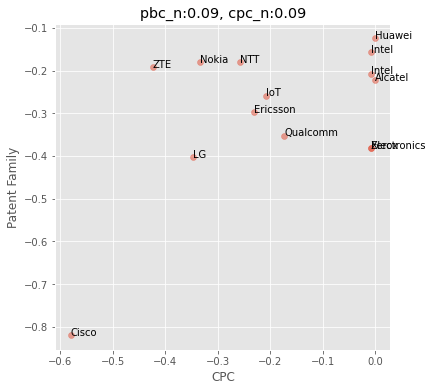

In [26]:
pbc_n=0.09
cpc_n=0.09
# c_df = scatter_plot(pbc_n,cpc_n)
# c_df = c_df.drop("Samsung Electronics Co Ltd")

plt.figure(figsize=(6,6))
plt.style.use('ggplot')
#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("CPC")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [27]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [28]:
competitor_ls

[4, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1]

In [29]:
c_df

,cpc,country
company,,
Cisco Systems,0.580175,0.819146
LG Electronics,0.347359,0.403619
Qualcomm,0.172963,0.352509
Ericsson,0.230460,0.297126
IoT Holdings,0.207469,0.259057
ZTE,0.423485,0.192603
Xerox,0.007448,0.382448
Electronics and Telecommunications Research Institute ETRI,0.007448,0.382448
Intel,0.007448,0.207448


In [30]:
# 公司名稱和類別
c_ls = list(c_df.index)

In [31]:
competitor_df = pd.DataFrame((zip(c_ls, competitor_ls)), columns = ['company', '2013_competitor'])

In [32]:
competitor_df

,company,2013_competitor
0,Cisco Systems,4
1,LG Electronics,2
2,Qualcomm,1
3,Ericsson,1
4,IoT Holdings,1
5,ZTE,2
6,Xerox,1
7,Electronics and Telecommunications Research In...,1
8,Intel,1
9,Intel Deutschland GmbH,1


In [33]:
competitor_df.to_csv("competitor_df/lda_us_2013.csv", index=False)